<a href="https://colab.research.google.com/github/LuisHTB/IT304-Grupo5/blob/main/Grupo_5_UFRJ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IT304 - Contratação de Energia para Grandes Clientes:


## Grupo 5
Luís Henrique Bandória ra:156449 \\
Hever \\
Roberto \\
Douglas

# Metodologia Utilizada:
## Cross-Industry Standard Process for Data Mining (CRISP-DM)
Neste trabalho será empregada a metodologia CRISP-DM para aquisição, tratamento e disponibilização dos dados de consumo do Centro de TEcnologia da UFRJ.

# Business Understanding
Verificar se há a possibildade de estimar, a partir dos dados das faturas de energia elétricas disponíveis, a demanda que deve ser contratada pela unidade consumidora Centro de Tecnologia da UFRJ uma vez que esta tenha migrado do Mercado Cativo de energia elétrica para o Mercado Livre. 

# Data Understanding:
Etapa de entendimento, coleta e visualização dos Dados. São realizadas a inicialização das bibliotecas do Python necessárias para a realização do trabalho e a leitura dos dados a partir do banco de dados disponível.

In [5]:
#Clonando o repositório do GitHub
!git clone https://github.com/LuisHTB/IT304-Grupo5.git

fatal: destination path 'IT304-Grupo5' already exists and is not an empty directory.


In [6]:
#Instalando o Arima
! pip install pmdarima

     |████████████████████████████████| 1.5MB 8.7MB/s 
     |████████████████████████████████| 2.1MB 35.4MB/s 
     |████████████████████████████████| 9.5MB 29.5MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [7]:
#Importando as bibliotecas necessárias
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from fancyimpute import KNN

sns.set()

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [8]:
#Importando a planilha com os dados digitalizados
abas_de_excel =  pd.ExcelFile("/content/IT304-Grupo5/data/Contas de energia UFRJ.xlsx")
#Separando apenas um das abas
UC1 = abas_de_excel.parse("UC1")

# Data Preparation:
Etapa de manipulação dos dados coletados, realizando a identificação e a eliminação de outliers e dados faltantes.

## Dados Faltantes:

### Identificação de Dados Faltantes

In [9]:
#Apresentando apenas as colunas que possuem dados nulos
data = []
for colm in UC1.columns[3:]:
  data.append([colm, UC1.shape[0]-UC1[colm].apply(np.isnan).sum(), UC1[colm].apply(np.isnan).sum(), (UC1[colm].apply(np.isnan).sum()/36)])
dados_faltantes = pd.DataFrame(data, columns=["Variavel", "Quantidade de dados Disponíveis", "Quantidade de dados Faltantes", "Percentagem de Dados Faltantes" ])
dados_faltantes = dados_faltantes[dados_faltantes["Quantidade de dados Faltantes"]>0].sort_values(by=['Quantidade de dados Faltantes'], ascending=False).reset_index(drop=True)
dados_faltantes['Percentagem de Dados Faltantes'] = dados_faltantes['Percentagem de Dados Faltantes'].astype(float).map("{:.2%}".format)
dados_faltantes

,Variavel,Quantidade de dados Disponíveis,Quantidade de dados Faltantes,Percentagem de Dados Faltantes
0,TX VISITA TÉCNICA UC-GA,0,36,100.00%
1,ICMS,0,36,100.00%
2,REAT_KVAR_NP,0,36,100.00%
3,TAR_ULTRAPASSAG,0,36,100.00%
4,DEMANDA_ULTRAPASSAG,0,36,100.00%
5,Indenização Mensal DMIC,0,36,100.00%
6,TAR_REATIVA_EXC_FP,0,36,100.00%
7,DEMANDA_REATIVA_EXC_FP,0,36,100.00%
8,TAR_DEMANDA_FP_SEM ICMS,0,36,100.00%
9,DEMANDA_FATURADA_FP SEM ICMS,0,36,100.00%


### Visualização de Dados Faltantes

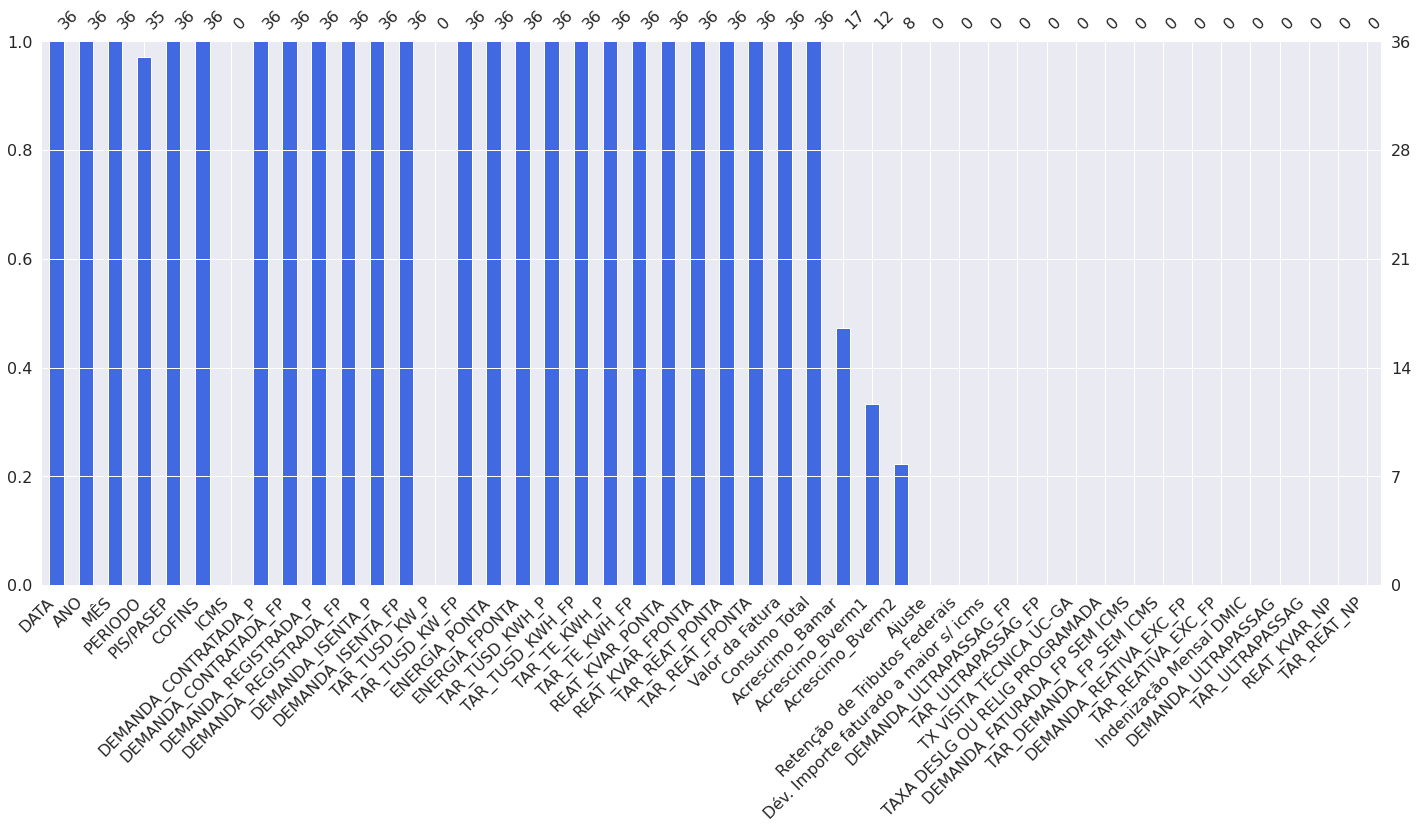

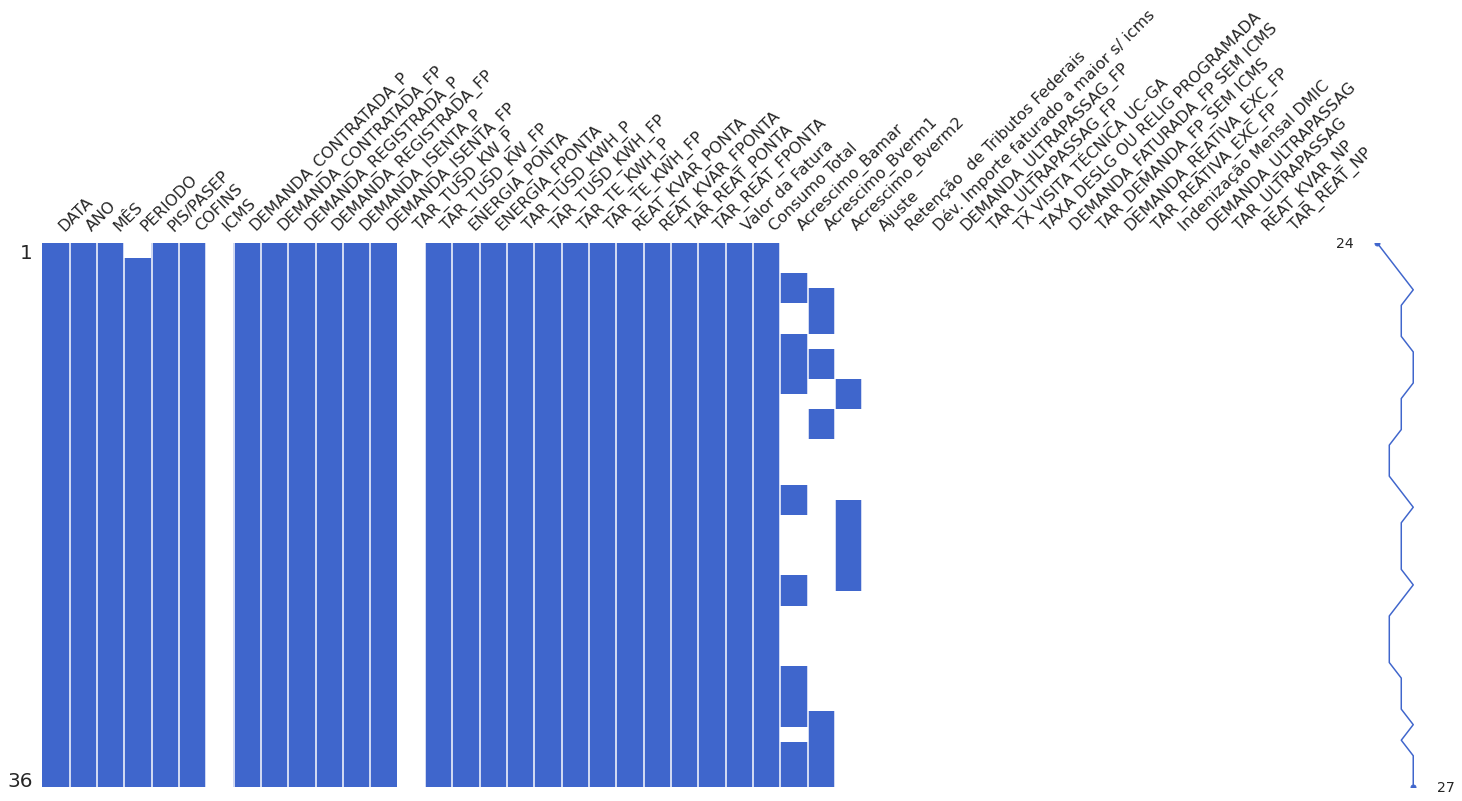

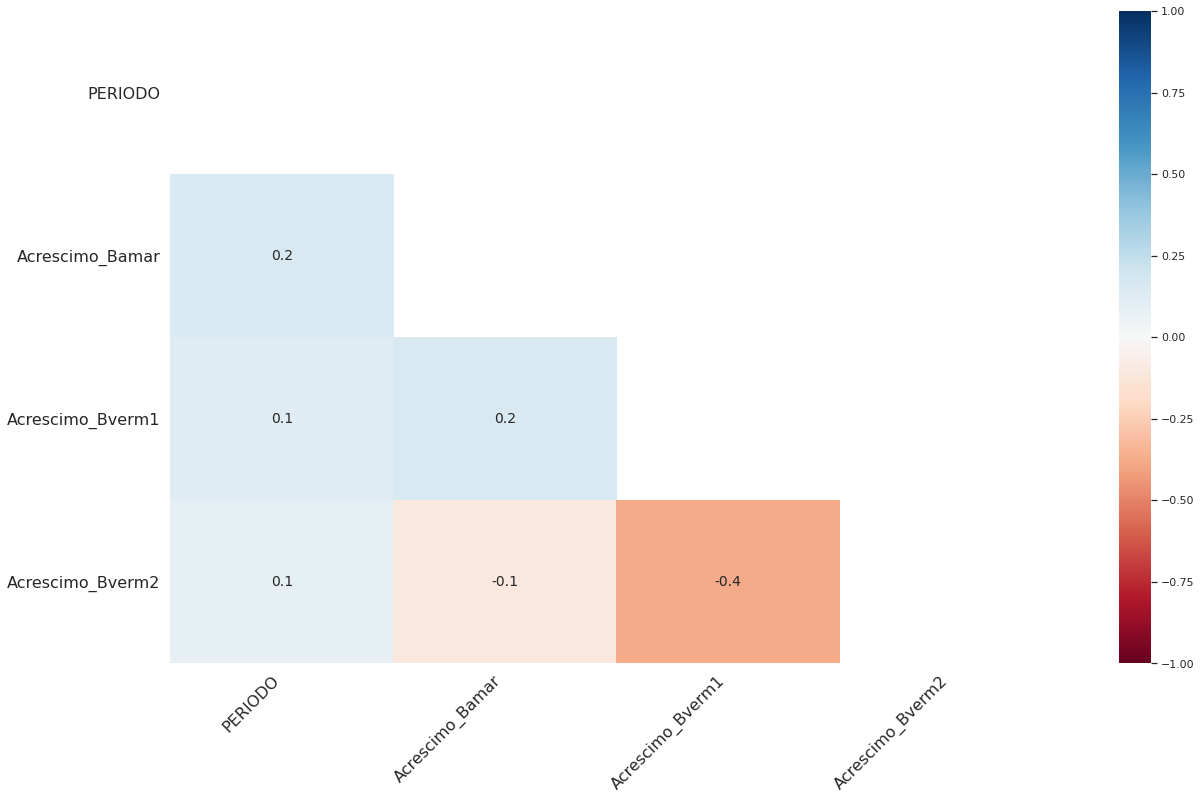

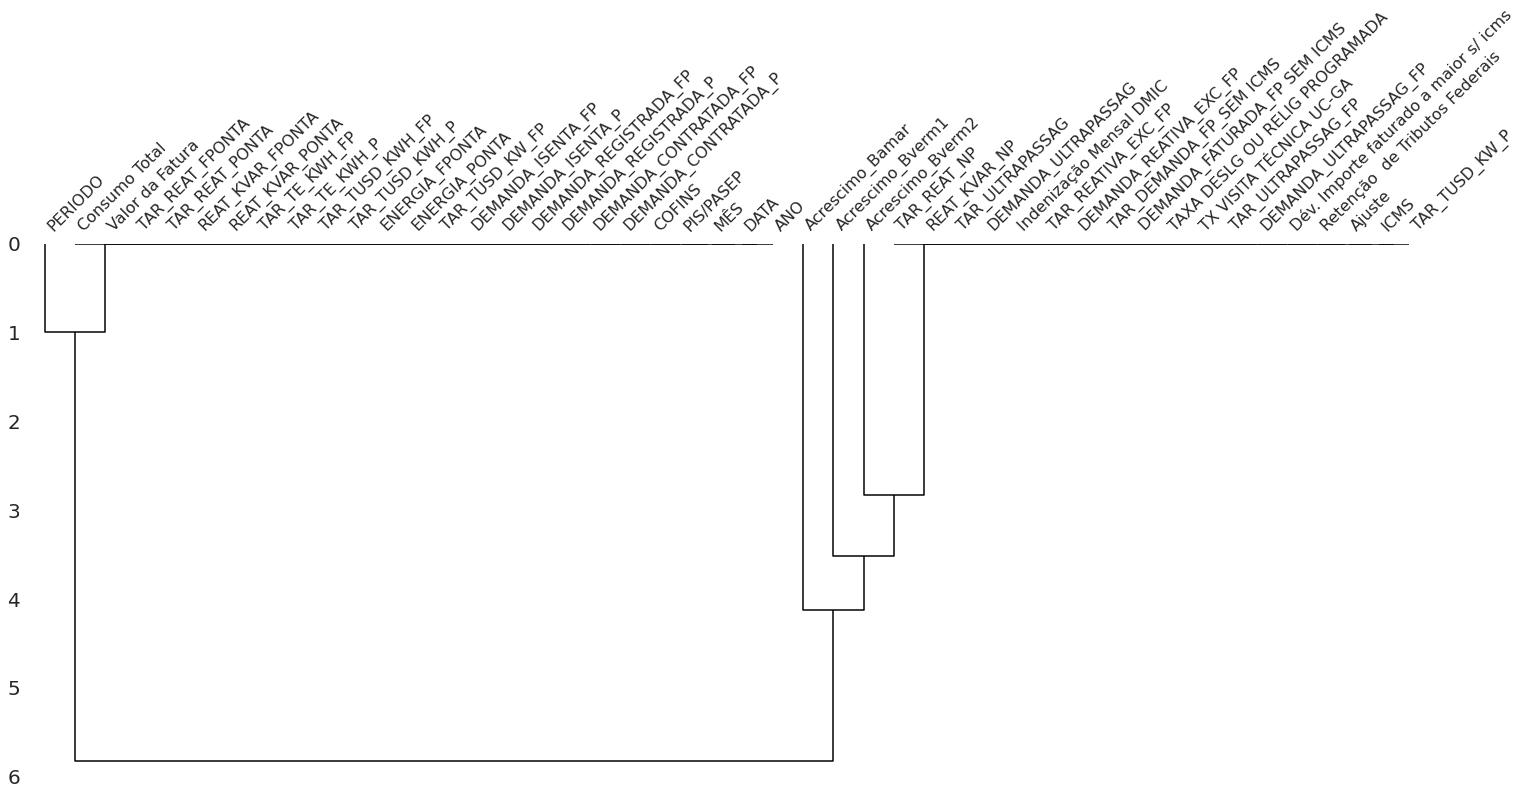

In [10]:
#Visualização da integridade do DataFrame
#Barras
fig = msno.bar(UC1, color="RoyalBlue")
fig_copy = fig.get_figure()
fig_copy.savefig('MissingDataBarPlot_-_Before.png', bbox_inches = 'tight')

#Matriz de posições
fig2 = msno.matrix(UC1, color = (0.25,0.4,0.8))
fig2_copy = fig2.get_figure()
fig2_copy.savefig('MissingDataMatrix_-_Before.png', bbox_inches = 'tight')

#Matriz de correlação
fig3 = msno.heatmap(UC1)
fig3_copy = fig3.get_figure()
fig3_copy.savefig('MissingDataCorrelation_-_Before.png', bbox_inches = 'tight')

#Dendograma
fig4 = msno.dendrogram(UC1)
fig4_copy = fig4.get_figure()
fig4_copy.savefig('MissingDataDendogram_-_Before.png', bbox_inches = 'tight')

### Eliminação de Dados Faltantes

In [11]:
#Removendo todas as colunas que tenham uma quantidade de dados inferior a 50%
UC1_df = UC1.drop(set(UC1.columns[UC1.isnull().mean() > 0.5]), 1)

### Visualização das Variáveis com Dados Faltantes

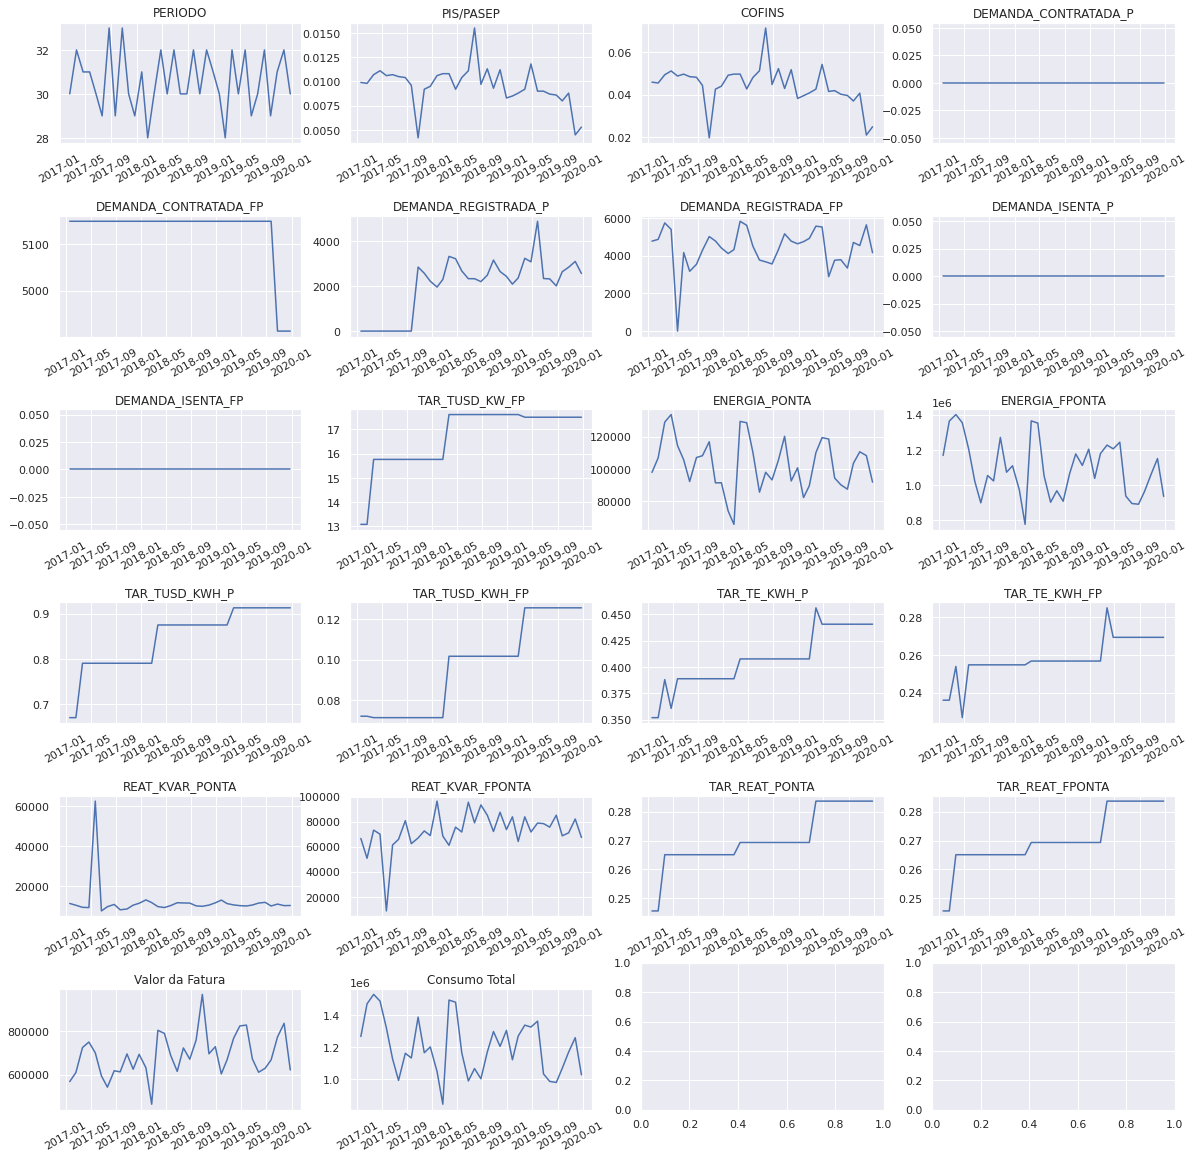

In [12]:
#Plotando todas as colunas do DF que tenham mais de 50% de dados disponíveis
f, axs = plt.subplots(5, 4,figsize=(20,20))
for i,col in enumerate(UC1_df.columns[3:]):
  plt.subplot(6, 4, i+1)
  plt.title(col)
  plt.plot(UC1_df.DATA, UC1_df[col])
  plt.xticks(rotation=30)  # Disable xticks.
  plt.subplots_adjust(hspace=0.6)

plt.savefig('DataFrameColumns_-_Before.png')

Text(0.5, 1.0, 'Período de Medição')

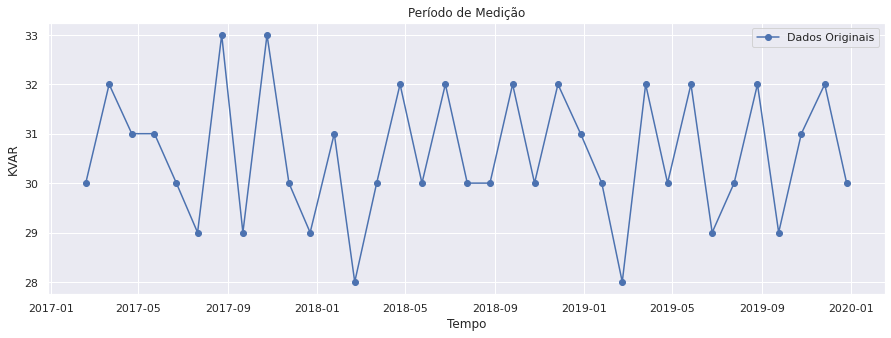

In [13]:
#Plotando todas as colunas do DF que tenham mais de 50% de dados disponíveis
#Plot com maior nível de detalhamento
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(UC1_df.DATA, UC1_df.PERIODO, marker='o', color="b")
plt.xlabel("Tempo")
plt.ylabel("KVAR")
plt.legend(['Dados Originais'])
plt.title("Período de Medição")

# plt.savefig('Periodo.png')


## Imputações

Nesta etapa os dados faltantes são preenchidos através de técnicas de Imputação.

### Imputação utilizando a Moda

A partir da análise dos dados na etapa anterior verificou-se que apenas a variável PERÍODO está incompleta, faltando apenas uma amostra. Por se tratar de uma variável dada em Dias optou-se pela imputação utilizando a Moda.

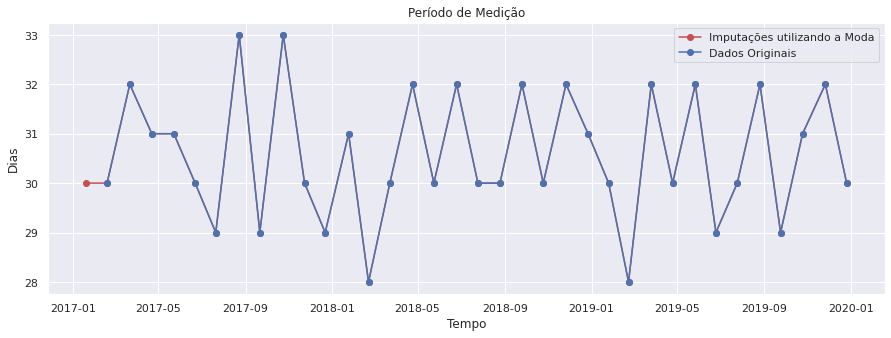

In [14]:
#Fazendo uma cópia do DataFrame
UC1_KNN = UC1_df.copy(deep= True)
imputer = SimpleImputer(strategy='most_frequent')
imputer = imputer.fit(UC1_KNN[["PERIODO"]])
UC1_KNN['PERIODO'] = imputer.transform(UC1_df[['PERIODO']]).ravel()

sns.set()
fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(UC1_KNN.DATA, UC1_KNN.PERIODO, marker='o', color="r")
plt.plot(UC1_df.DATA, UC1_df.PERIODO, marker='o', color="b")
plt.xlabel("Tempo")
plt.ylabel("Dias")
plt.legend(['Imputações utilizando a Moda', 'Dados Originais'])
plt.title("Período de Medição")
plt.savefig("Period_-_Imputation.png")

## Outliers
Nesta etapa os dados discrepantes, isto é , os outliers presentes em cada variável são identificados e substituídos.

### Identificação de Outliers - BoxPlot
Nestas figuras é possível identificar a média dos valores juntamente com uma margem de erro esperada para aquela variável. Valores que se encontram fora dos limites estabelecidos por essa margem são considerados outliers.

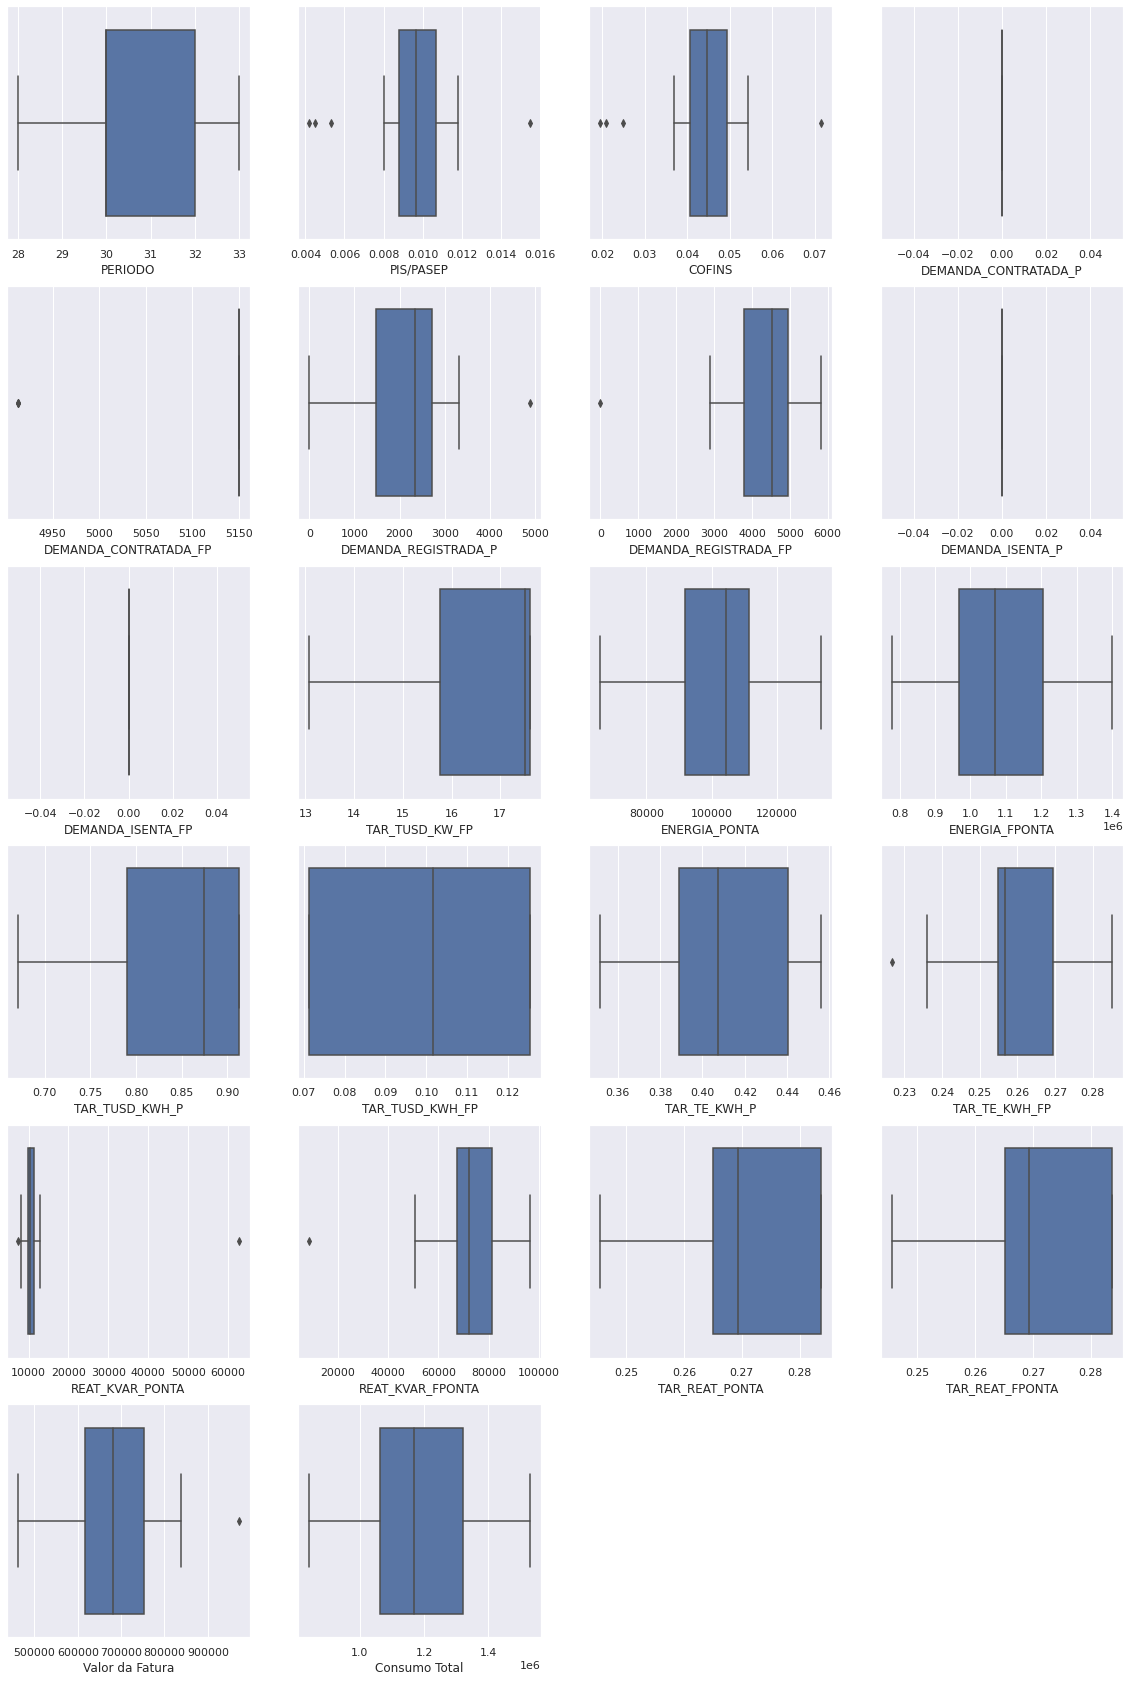

In [15]:
f, axs = plt.subplots(5, 4,figsize=(20,30))
for i,col in enumerate(UC1_KNN.columns[3:]):
  plt.subplot(6, 4, i+1)
  sns.boxplot(x=UC1_KNN[col])
  
plt.savefig("BoxPlot_-_Before.png")


### Remoção de Outliers

#### Interquartile range

In [16]:
def outlier_IQR(datacolumn):
  sorted(datacolumn)
  Q1,Q3 = np.percentile(datacolumn , [25,75])
  IQR = Q3 - Q1
  lower_range = Q1 - (1.5 * IQR)
  upper_range = Q3 + (1.5 * IQR)
  return lower_range,upper_range

#### Demanda Registrada FP

In [17]:
lowerbound , upperbound = outlier_IQR(UC1_KNN["DEMANDA_REGISTRADA_FP"])
UC1_KNN["DEMANDA_REGISTRADA_FP"][(UC1_KNN["DEMANDA_REGISTRADA_FP"] < lowerbound) | (UC1_KNN["DEMANDA_REGISTRADA_FP"] > upperbound)]

4    0.0
Name: DEMANDA_REGISTRADA_FP, dtype: float64

In [18]:
index_value = [4]
UC1_KNN.at[index_value, 'DEMANDA_REGISTRADA_FP'] = UC1_KNN.DEMANDA_REGISTRADA_FP.mean()

#### Demanda Registrada P

In [19]:
lowerbound , upperbound = outlier_IQR(UC1_KNN["DEMANDA_REGISTRADA_P"])
UC1_KNN["DEMANDA_REGISTRADA_P"][(UC1_KNN["DEMANDA_REGISTRADA_P"] < lowerbound) | (UC1_KNN["DEMANDA_REGISTRADA_P"] > upperbound)]

28    4890.0
Name: DEMANDA_REGISTRADA_P, dtype: float64

In [20]:
index_value = [28]
UC1_KNN.at[index_value, 'DEMANDA_REGISTRADA_P'] = UC1_KNN['DEMANDA_REGISTRADA_P'].mean()

#### TAR_TE_KWH_FP

In [21]:
lowerbound , upperbound = outlier_IQR(UC1_KNN["TAR_TE_KWH_FP"])
UC1_KNN["TAR_TE_KWH_FP"][(UC1_KNN["TAR_TE_KWH_FP"] < lowerbound) | (UC1_KNN["TAR_TE_KWH_FP"] > upperbound)]

3    0.22662
Name: TAR_TE_KWH_FP, dtype: float64

In [22]:
index_value = [3]
UC1_KNN.at[index_value, 'TAR_TE_KWH_FP'] = UC1_KNN.TAR_TE_KWH_FP.mean()

#### REAT_KVAR_PONTA

In [23]:
lowerbound , upperbound = outlier_IQR(UC1_KNN["REAT_KVAR_PONTA"])
UC1_KNN["REAT_KVAR_PONTA"][(UC1_KNN["REAT_KVAR_PONTA"] < lowerbound) | (UC1_KNN["REAT_KVAR_PONTA"] > upperbound)]

4    62640
5     7413
Name: REAT_KVAR_PONTA, dtype: int64

In [24]:
index_value = [4]
UC1_KNN.at[index_value, 'REAT_KVAR_PONTA'] = UC1_KNN.REAT_KVAR_PONTA.mean()
index_value = [5]
UC1_KNN.at[index_value, 'REAT_KVAR_PONTA'] = UC1_KNN.REAT_KVAR_PONTA.mean()

#### REAT_KVAR_FPONTA

In [25]:
lowerbound , upperbound = outlier_IQR(UC1_KNN["REAT_KVAR_FPONTA"])
UC1_KNN["REAT_KVAR_FPONTA"][(UC1_KNN["REAT_KVAR_FPONTA"] < lowerbound) | (UC1_KNN["REAT_KVAR_FPONTA"] > upperbound)]

4    8808
Name: REAT_KVAR_FPONTA, dtype: int64

In [26]:
index_value = [4]
UC1_KNN.at[index_value, "REAT_KVAR_FPONTA"] = UC1_KNN.REAT_KVAR_FPONTA.mean()

#### Visualização dos Dados após a remoção de Outliers

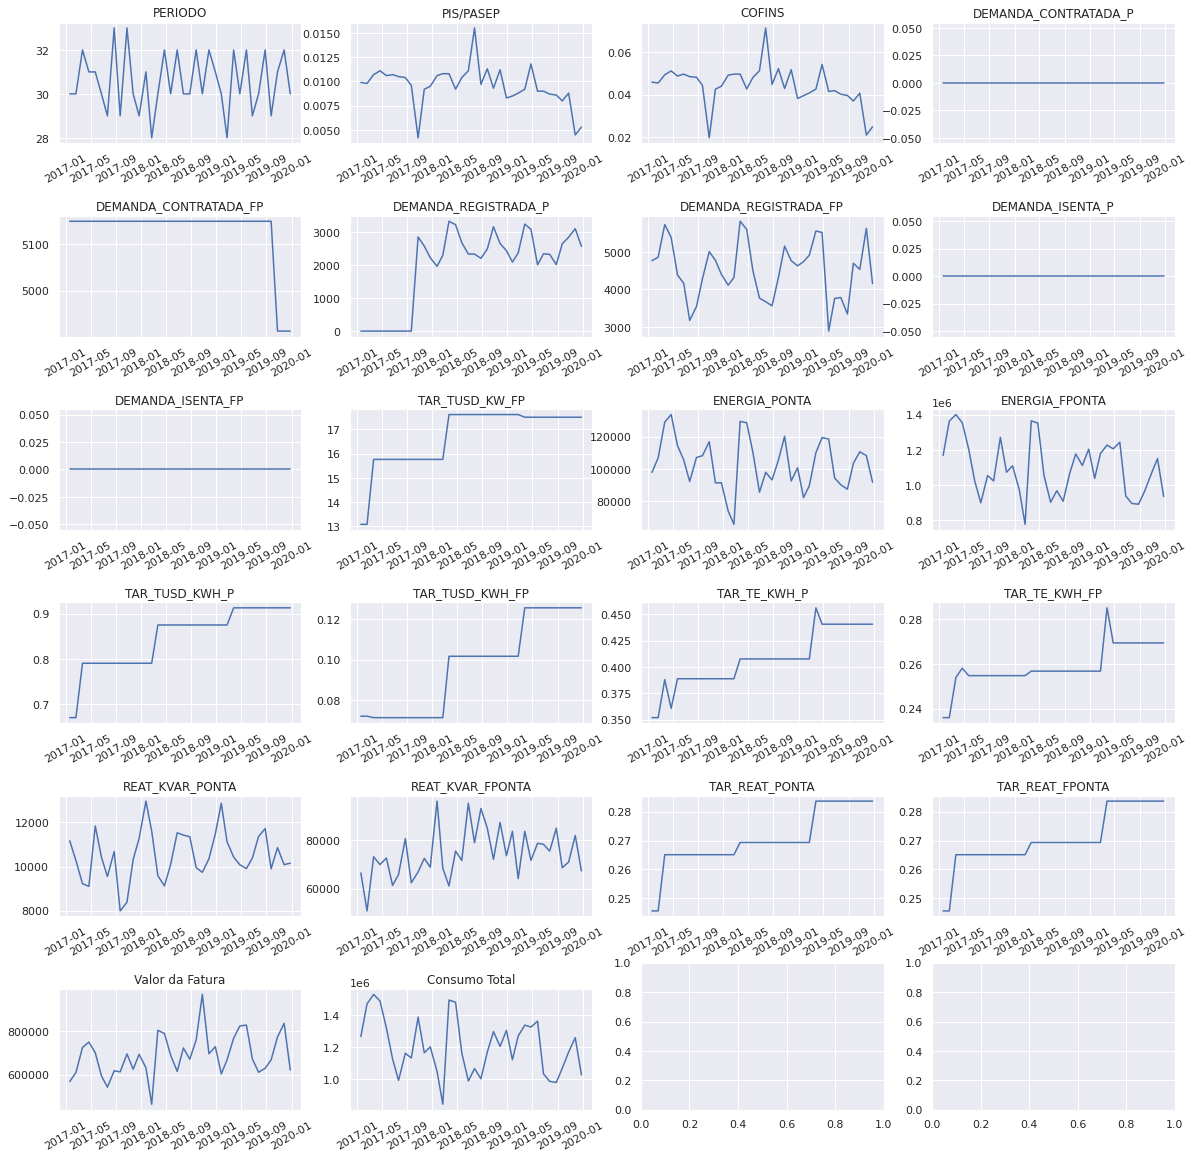

In [27]:
#Plotando todas as colunas do DF que tenham mais de 50% de dados disponíveis após a remoção de outliers
f, axs = plt.subplots(5, 4,figsize=(20,20))
for i,col in enumerate(UC1_KNN.columns[3:]):
  plt.subplot(6, 4, i+1)
  plt.title(col)
  plt.plot(UC1_KNN.DATA, UC1_KNN[col])
  plt.xticks(rotation=30)  # Disable xticks.
  plt.subplots_adjust(hspace=0.6)

plt.savefig('DataFrameColumns_-_Outliers.png')

#### Box Plot após a remoção de Outliers

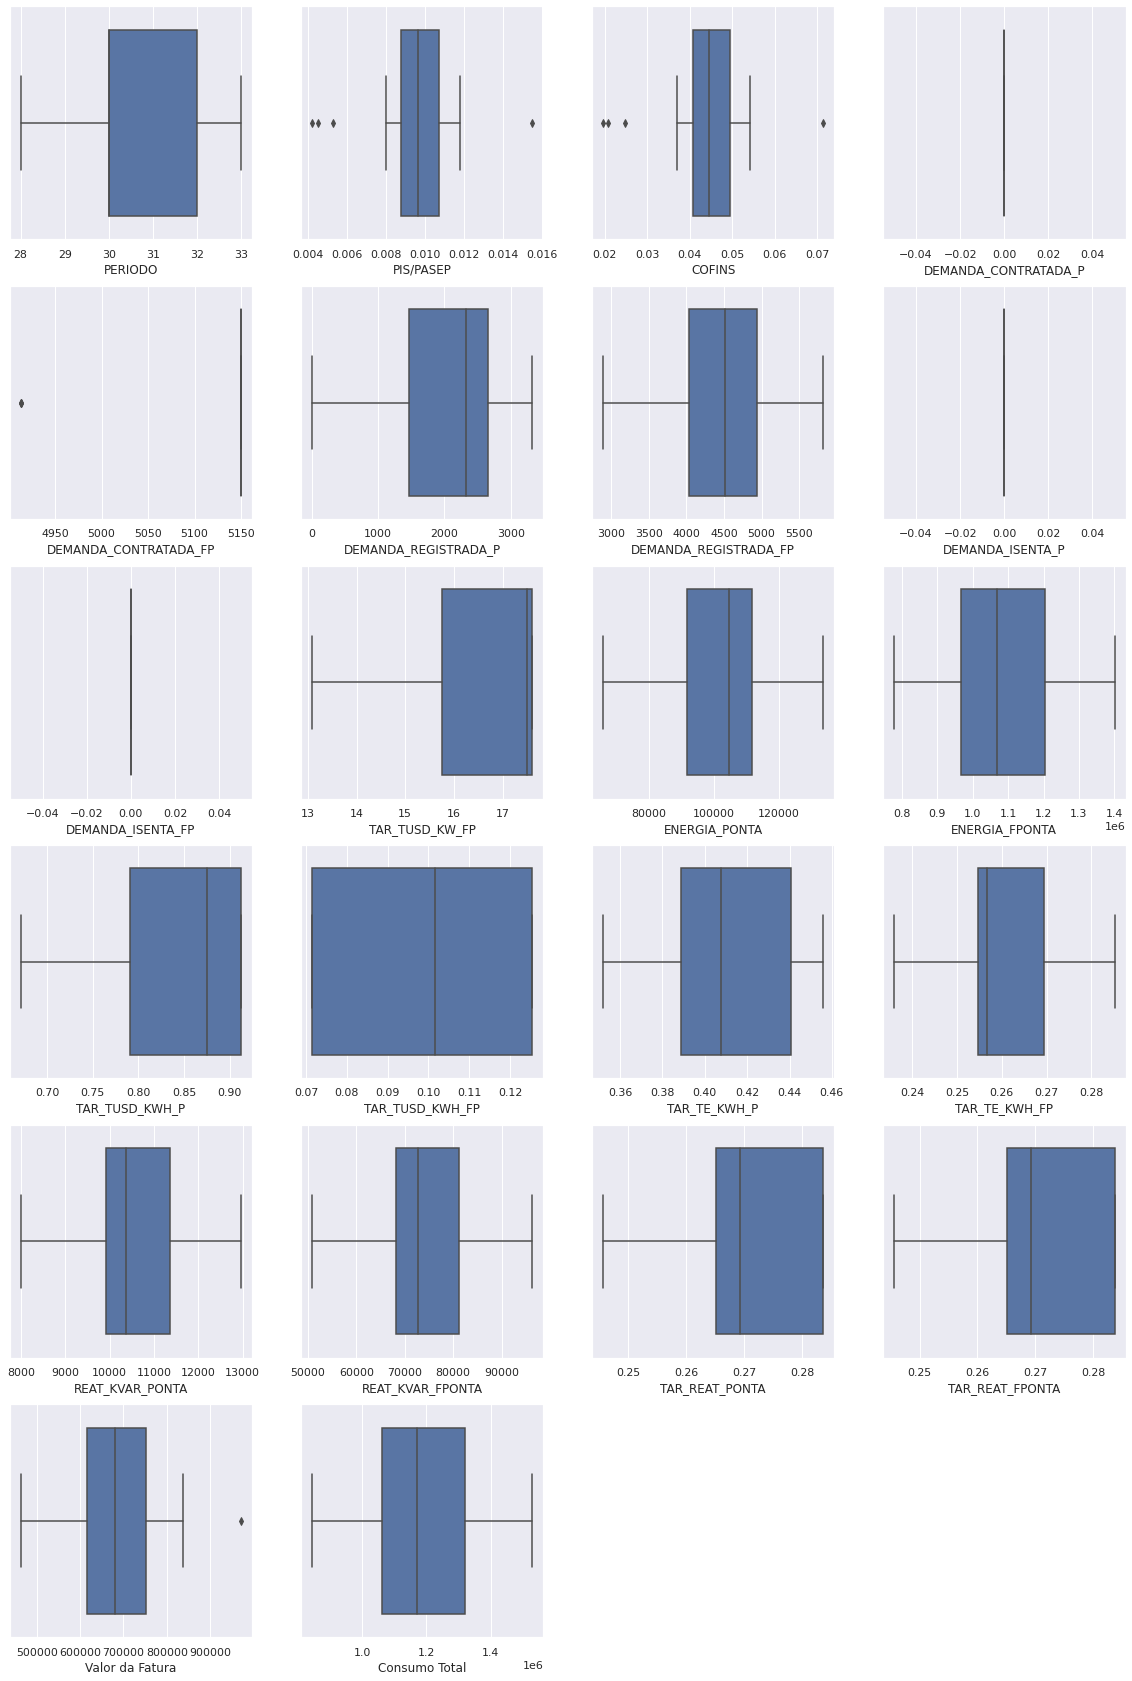

In [28]:
f, axs = plt.subplots(5, 4,figsize=(20,30))
for i,col in enumerate(UC1_KNN.columns[3:]):
  plt.subplot(6, 4, i+1)
  sns.boxplot(x=UC1_KNN[col])
  
plt.savefig("BoxPlot_-_Outliers.png")

## Visualização dos dados com Imputações e sem Outliers

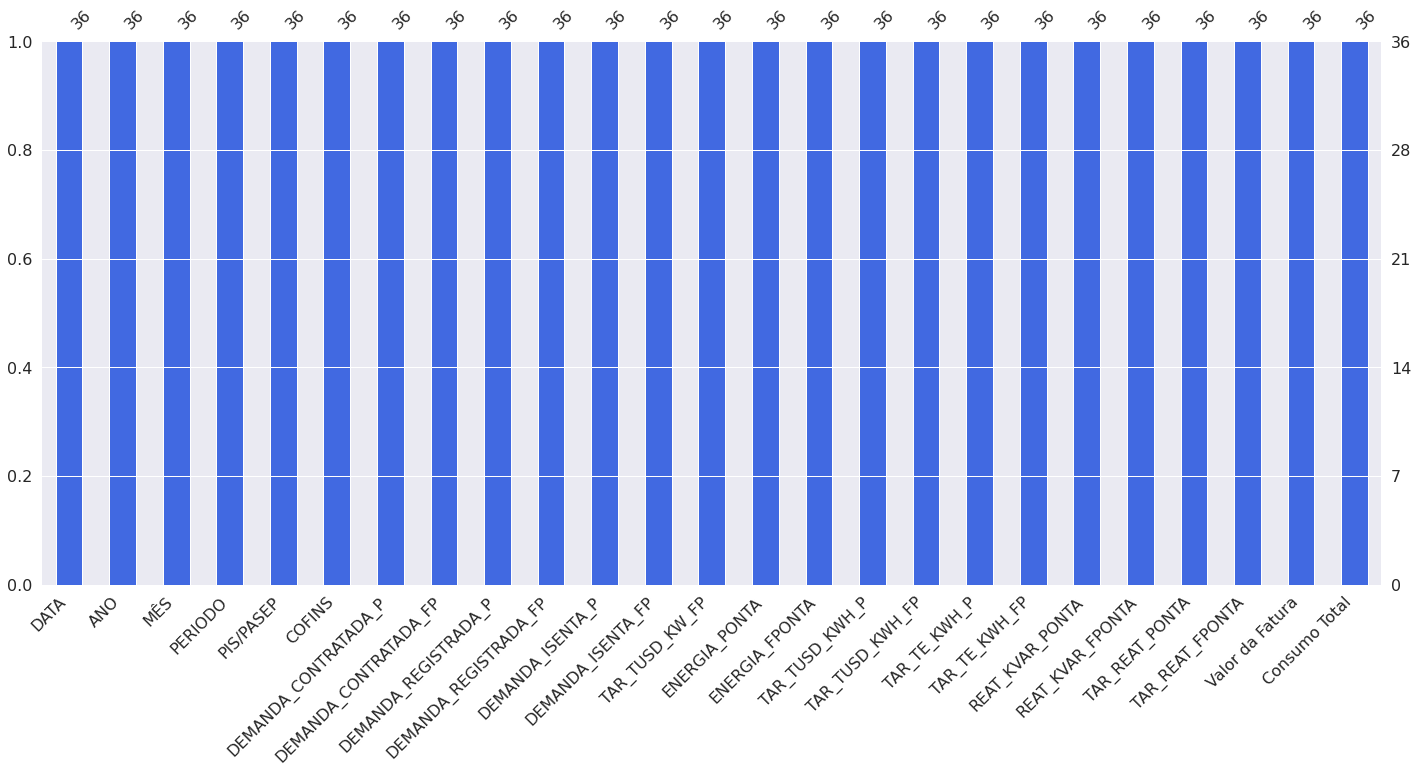

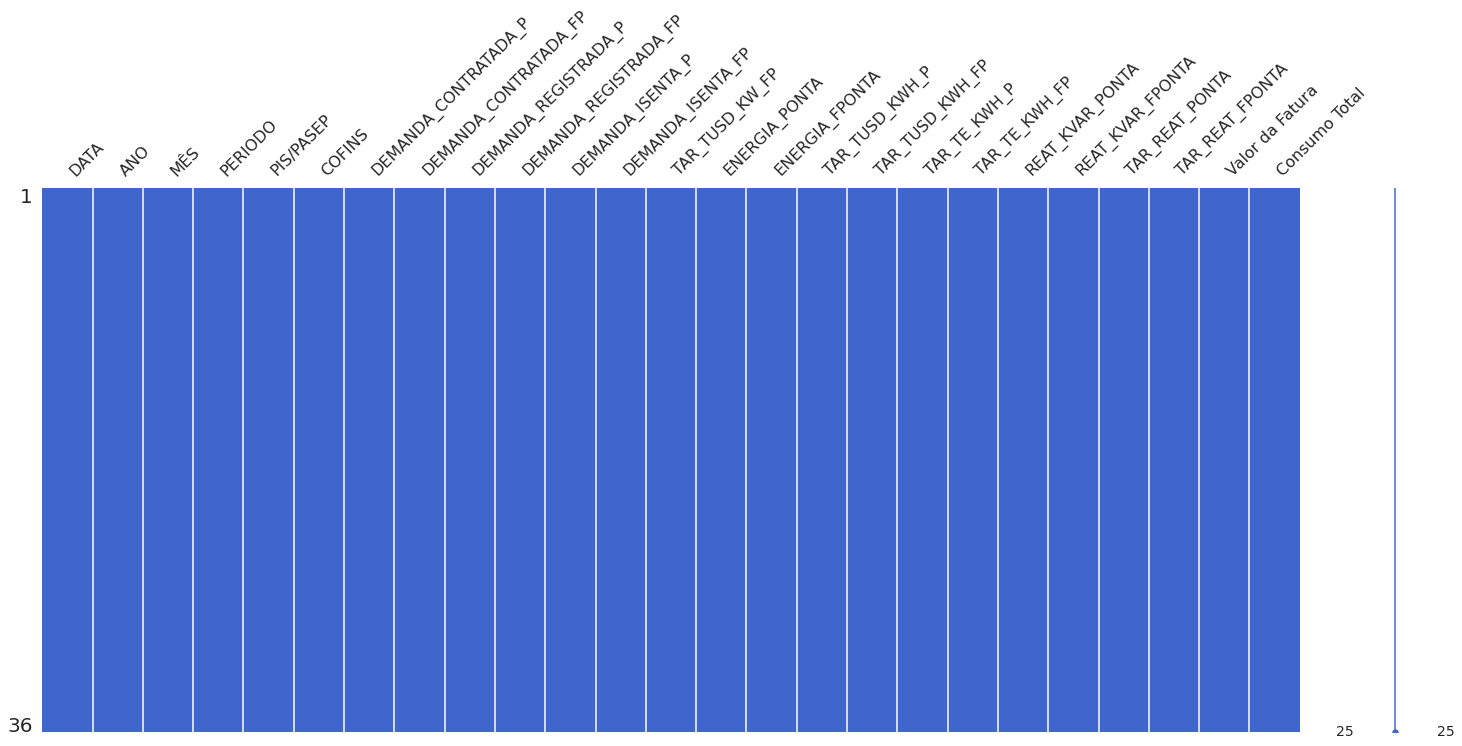

In [29]:
#Visualização da integridade do DataFrame
#Barras
fig = msno.bar(UC1_KNN, color="RoyalBlue")
fig_copy = fig.get_figure()
fig_copy.savefig('MissingDataBarPlot_-_After.png', bbox_inches = 'tight')

#Matriz de posições
fig2 = msno.matrix(UC1_KNN, color = (0.25,0.4,0.8))
fig2_copy = fig2.get_figure()
fig2_copy.savefig('MissingDataMatrix_-_After.png', bbox_inches = 'tight')

# Modeling
Nesta etapa é construído um modelo para representar o comportamento do sistema estudado a partir dos dados disponíveis.

In [30]:
#Modelagem da Demanda Contratada FP
df_train = UC1_KNN["DEMANDA_REGISTRADA_FP"].iloc[:28]
df_test = UC1_KNN["DEMANDA_REGISTRADA_FP"].iloc[28:]

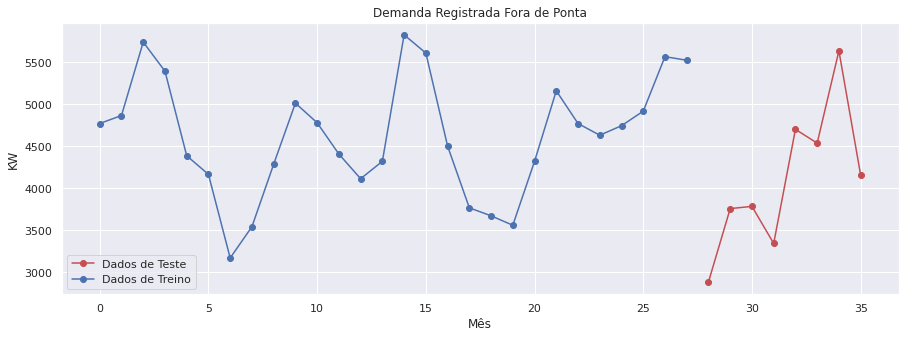

In [31]:
# #Modelagem da Demanda Contratada FP
# df_train = UC1_KNN["DEMANDA_REGISTRADA_FP"].iloc[:28]
# df_test = UC1_KNN["DEMANDA_REGISTRADA_FP"].iloc[28:]

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_test, marker='o', color="r")
plt.plot(df_train, marker='o', color="b")
plt.xlabel("Mês")
plt.ylabel("KW")
plt.legend([ 'Dados de Teste', 'Dados de Treino'])
plt.title("Demanda Registrada Fora de Ponta")
plt.savefig("TestTrain_-_DemandaRegFP.png")

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=226.402, Time=0.07 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=inf, Time=0.22 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=0.28 sec
 ARIMA(0,1,0)(1,1,0)[12]             : AIC=223.262, Time=0.09 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=inf, Time=0.63 sec
 ARIMA(0,1,0)(1,1,1)[12]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(2,1,1)[12]             : AIC=inf, Time=0.75 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=inf, Time=0.14 sec
 ARIMA(1,1,1)(1,1,0)[12]             : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(1,1,0)[12] intercept   : AIC=225.168, Time=0.20 sec

Best model:  ARIMA(0,1,0)(1,1,0)[12]          
Total fit time: 3.015 seconds


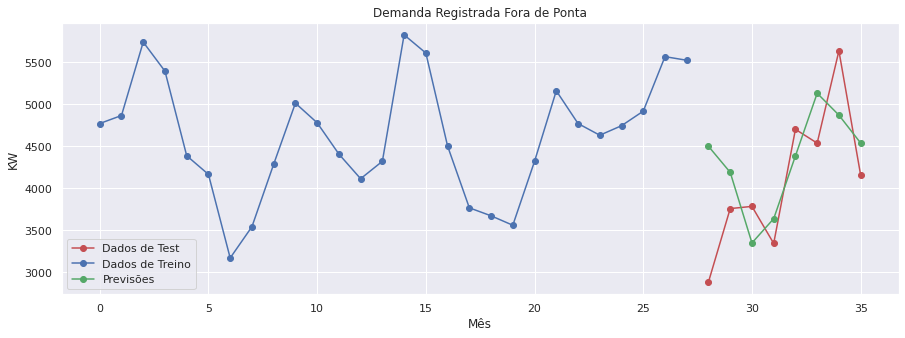

In [32]:
adf_test = ADFTest(alpha=0.05)
adf_test.should_diff(df_train)
arima_model = auto_arima(df_train, start_p=0, d=1, start_q=0, max_p=5, max_d=5, max_q=5, start_P=0, D=1, start_Q=0, max_P = 5, max_D = 5, max_Q=5, m=12, seasonal = True, error_action = 'warn', trace = True, supress_warning = True, stepwise = True, random_state= 20, nfits = 50)
arima_model.summary()

predicoes = pd.DataFrame(arima_model.predict(n_periods = 8), index = df_test.index)
predicoes.columns = ['predicoes']

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(df_test, marker='o', color="r")
plt.plot(df_train, marker='o', color="b")
plt.plot(predicoes, marker='o', color="g")
plt.xlabel("Mês")
plt.ylabel("KW")
plt.legend([ 'Dados de Test', 'Dados de Treino', 'Previsões'])
plt.title("Demanda Registrada Fora de Ponta")
plt.savefig("Prediction-_DemandaRegFP.png")

# Avaliação
Avaliação dos resultados obtidos, analisando se são de ajuda para responder a pergunta de interesse. Será utilizada a RMSE, dada pela equação

$R M S E=\sqrt{\sum_{i=1}^{n} \frac{\left(\hat{y}_{i}-y_{i}\right)^{2}}{n}}$

In [33]:
def RMSE(yh, y):
  er = yh - y
  RMSE = sum(er*er/len(er))**0.5
  return 

In [37]:
np.mean(RMSE(df_test.values, predicoes.values))

# Banco de Dados Final com imputações pela Moda e remoção de outliers pelo método Interquartile Range

In [35]:
UC1_KNN.describe().to_csv("Description_-_DataFinal.xlsx")

In [36]:
UC1_KNN.to_csv(r'UFRJ_-_Final.xlsx', index = False)